# Import libraries

In [1]:
import cryptocompare
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from tqdm import tqdm


from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA

# Get data

As we mentioned earlier, we are going to get BTC price using `cryptocompare` library. Note that, to access the CryptoCompare API, you need an API key. You can get a free API key by signing up on the CryptoCompare website. Once you have your API key, you can set it using `cryptocompare.set_api_key('YOUR_API_KEY')`. Don't forget to install the library using `pip install cryptocompare`. 

In [4]:

key = # YOUR_API_KEY
cryptocompare.cryptocompare._set_api_key_parameter(key)

start = datetime.strptime('2015-01-01', '%Y-%m-%d')
end = datetime.now()

start_timestamp = int(start.timestamp())
end_timestamp = int(end.timestamp())


data = []
limit = 2000  # Maximum number of data points per request (CryptoCompare's limit)
toTs = end_timestamp

while toTs > start_timestamp:
    historical_data = cryptocompare.get_historical_price_hour('BTC', currency='USD', toTs=toTs, limit = limit)
    if not historical_data:
        break
    data.extend(historical_data)
    toTs = historical_data[0]['time'] 

In [6]:
# Convert to DataFrame
df = pd.DataFrame(data)
df['time'] = pd.to_datetime(df['time'], unit='s')
df = df.sort_values('time')
df

,time,high,low,open,volumefrom,volumeto,close,conversionType,conversionSymbol
84042,2014-10-11 10:00:00,361.51,353.58,361.32,745.63,2.665689e+05,354.49,direct,
84043,2014-10-11 11:00:00,357.10,353.14,354.49,598.43,2.132907e+05,356.04,direct,
84044,2014-10-11 12:00:00,356.68,352.63,356.04,513.96,1.824632e+05,355.02,direct,
84045,2014-10-11 13:00:00,358.03,354.12,355.02,555.20,2.023207e+05,355.37,direct,
84046,2014-10-11 14:00:00,355.66,351.52,355.37,610.46,2.212936e+05,351.52,direct,
...,...,...,...,...,...,...,...,...,...
1996,2024-08-02 14:00:00,65317.55,63044.00,65185.37,4454.04,2.861049e+08,63102.88,direct,
1997,2024-08-02 15:00:00,63570.46,62389.78,63102.88,4457.95,2.808035e+08,63375.94,direct,
1998,2024-08-02 16:00:00,63546.53,62919.79,63375.94,2529.01,1.599835e+08,63248.63,direct,
1999,2024-08-02 17:00:00,63398.48,63015.57,63248.63,1136.85,7.183959e+07,63034.92,direct,


In [7]:
# Save dataframe as a csv file
df.to_csv("hourly_data_2024_08_02.csv", index = False)

# Load Data

In [2]:
df = pd.read_csv("hourly_data_2024_08_02.csv", parse_dates =['time'])
df.set_index('time', inplace= True) # set `time` as index of dataframe
df = df[~df.index.duplicated(keep='first')] # drop duplicated indices
df

,high,low,open,volumefrom,volumeto,close,conversionType,conversionSymbol
time,,,,,,,,
2014-10-11 10:00:00,361.51,353.58,361.32,745.63,2.665689e+05,354.49,direct,NaN
2014-10-11 11:00:00,357.10,353.14,354.49,598.43,2.132907e+05,356.04,direct,NaN
2014-10-11 12:00:00,356.68,352.63,356.04,513.96,1.824632e+05,355.02,direct,NaN
2014-10-11 13:00:00,358.03,354.12,355.02,555.20,2.023207e+05,355.37,direct,NaN
2014-10-11 14:00:00,355.66,351.52,355.37,610.46,2.212936e+05,351.52,direct,NaN
...,...,...,...,...,...,...,...,...
2024-08-02 14:00:00,65317.55,63044.00,65185.37,4454.04,2.861049e+08,63102.88,direct,NaN
2024-08-02 15:00:00,63570.46,62389.78,63102.88,4457.95,2.808035e+08,63375.94,direct,NaN
2024-08-02 16:00:00,63546.53,62919.79,63375.94,2529.01,1.599835e+08,63248.63,direct,NaN


Text(0.5, 1.0, 'Bitcoin Close Price (2015 - July 2024)')

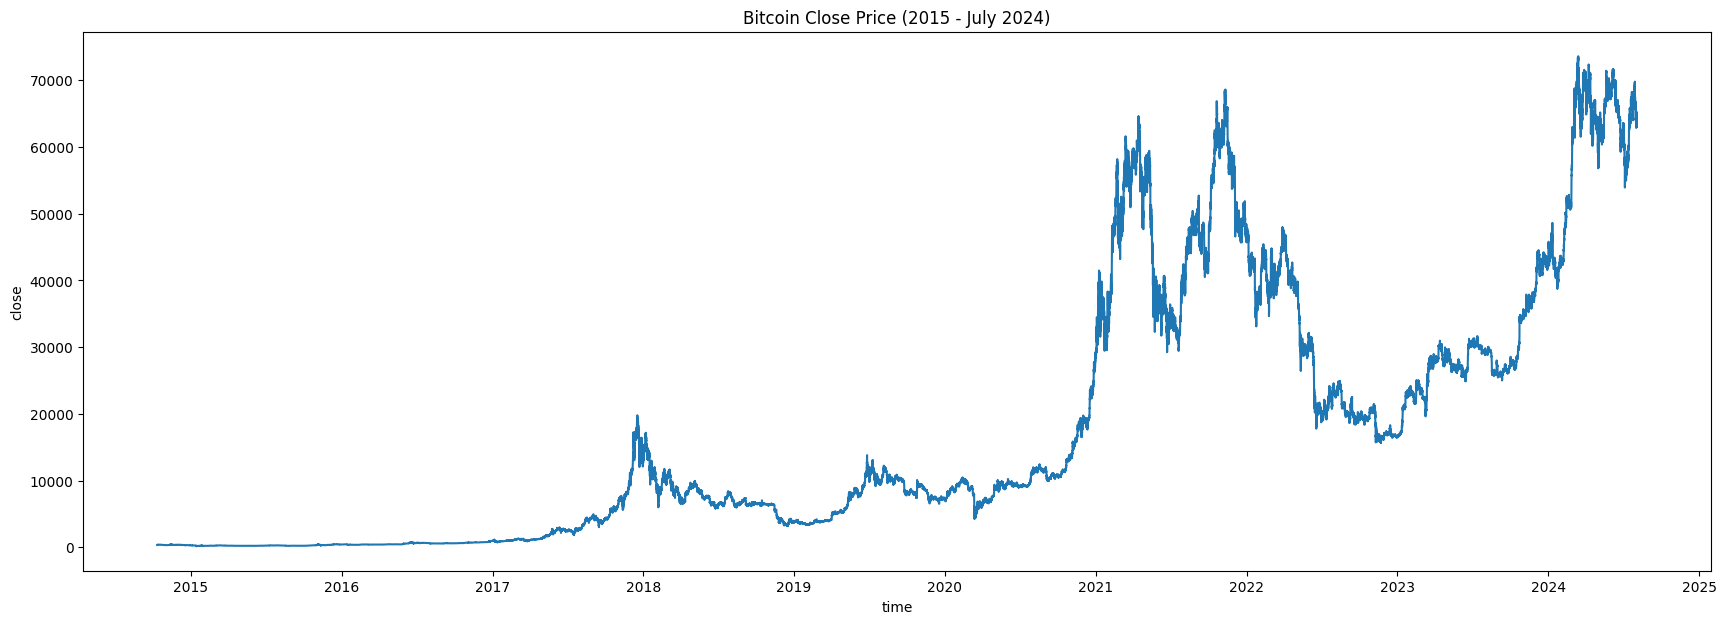

In [4]:
plt.figure(figsize = (21,7))

sns.lineplot(data = df, x = 'time', y = 'close')

plt.title("Bitcoin Close Price (2015 - July 2024)")

Based on the above plot, we conclude that very old data points are not informataive. Therefor, we will consider BTC price starting from 2018.

Text(0.5, 1.0, 'Bitcoin Close Price (Jan 2018 - July 2024)')

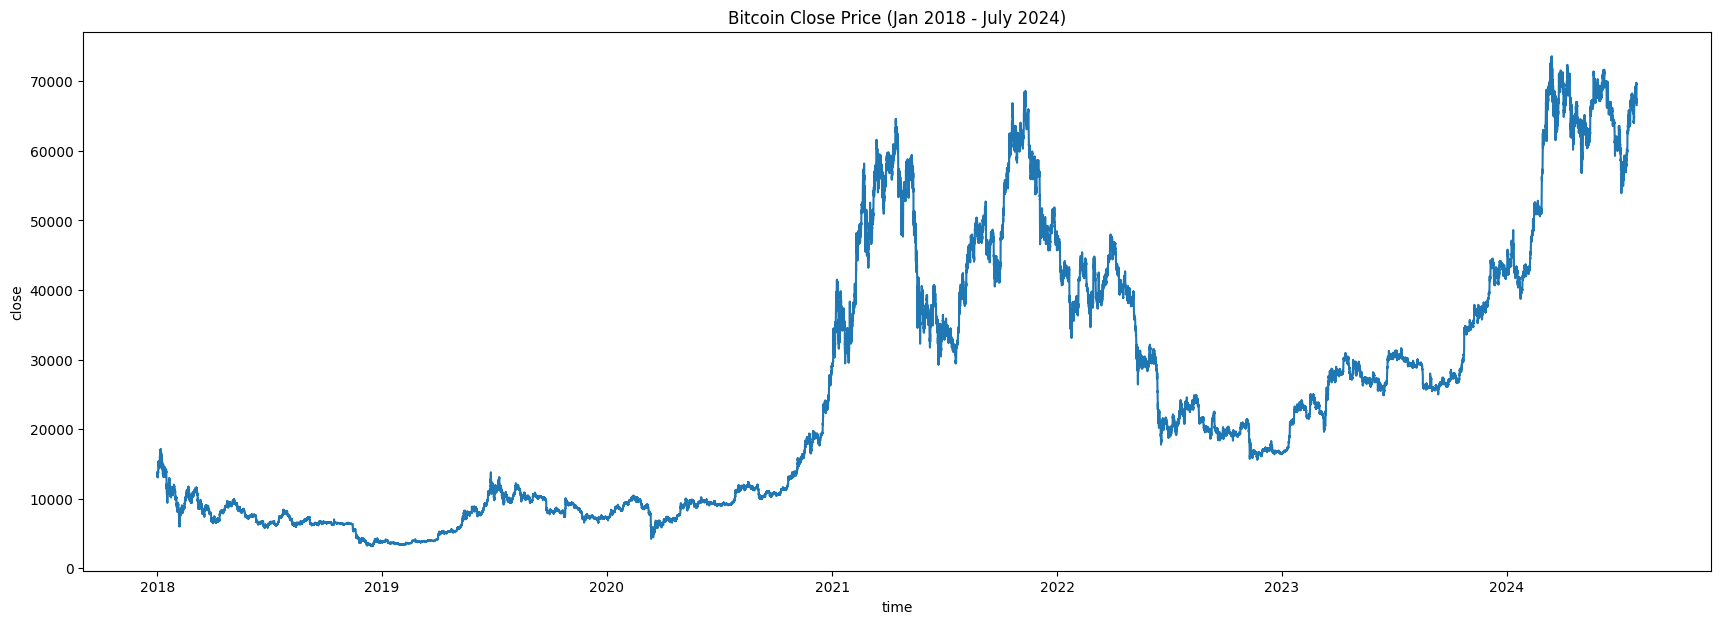

In [5]:
df = df[(df.index >= "2018-01-01") & (df.index <= "2024-07-30")] 

plt.figure(figsize = (21,7))

sns.lineplot(data = df, x = 'time', y = 'close')

plt.title("Bitcoin Close Price (Jan 2018 - July 2024)")

# Calculate Weekly ROI

## Calculation of Weekly ROI (Monday to Monday)

The main question is forecastibg weekly ROI (Monday 20:00 PM (GMT) to next Monday 20:00 PM (GMT)), and in following code snippet, we are going to compute this metric.

In [6]:
def roi_df(dataframe, day, hour):
    df_out = pd.DataFrame()

    df_out["Day_Hour_Close"] = dataframe[(dataframe.index.hour == hour) &(dataframe.index.weekday == day)]["close"] 
    df_out["Next_Day_Hour_Close"] = df_out["Day_Hour_Close"].shift(-1)
    df_out.dropna(inplace = True)
    df_out["7_Day_ROI"]= (df_out['Next_Day_Hour_Close'] - df_out['Day_Hour_Close']) / df_out['Day_Hour_Close'] * 100
    df_out.drop(columns = ["Day_Hour_Close", "Next_Day_Hour_Close"], inplace = True)

    return df_out

df_roi_mm = roi_df(df, day = 0, hour = 20)
df_roi_mm

,7_Day_ROI
time,
2018-01-01 20:00:00,11.286552
2018-01-08 20:00:00,-8.191629
2018-01-15 20:00:00,-24.274411
2018-01-22 20:00:00,8.032634
2018-01-29 20:00:00,-35.991637
...,...
2024-06-24 20:00:00,6.324530
2024-07-01 20:00:00,-11.028400
2024-07-08 20:00:00,13.378117


As you can see, this DataFrame doesn't contain a large amount of data, so we cannot expect our models to achieve strong performance on this dataset. To address this issue, we calculate the weekly ROI for every day of the week and not only at 20:00 PM GMT but also at intervals of every four and eight hours. This additional data improves the model's performance, but it also introduces a challenge: a long forecasting horizon. For instance, if we consider the weekly ROI at every eight hours (4:00 AM, 12:00 PM, and 20:00 PM), the forecasting horizon will be 3 * 7 = 21. If we consider data every four hours, the forecasting horizon extends to 6 * 7 = 42. This long forecasting horizon can potentially decrease the accuracy of our predictions. To mitigate this issue, we need to select an optimized window size.

## Every Eight Hours ROI

In [7]:
df_8h = df[(df.index.hour == 4) | (df.index.hour == 12)  | (df.index.hour == 20)][["close"]]
df_8h

,close
time,
2018-01-01 04:00:00,13631.46
2018-01-01 12:00:00,13229.17
2018-01-01 20:00:00,13464.52
2018-01-02 04:00:00,13126.32
2018-01-02 12:00:00,13625.40
...,...
2024-07-28 12:00:00,68006.87
2024-07-28 20:00:00,68007.47
2024-07-29 04:00:00,69365.67


In [8]:
def roi_df(dataframe, day, hour):
    df_out = pd.DataFrame()

    df_out["Day_Hour_Close"] = dataframe[(dataframe.index.hour == hour) &(dataframe.index.weekday == day)]["close"] 
    df_out["Next_Day_Hour_Close"] = df_out["Day_Hour_Close"].shift(-1)
    df_out.dropna(inplace = True)
    df_out["7_Day_ROI"]= (df_out['Next_Day_Hour_Close'] - df_out['Day_Hour_Close']) / df_out['Day_Hour_Close'] * 100
    df_out.drop(columns = ["Day_Hour_Close", "Next_Day_Hour_Close"], inplace = True)

    return df_out


df_roi_8h = roi_df(df_8h, day=0, hour = 4)
df_roi12 = roi_df(df_8h, day =0, hour =12)
df_roi20 = roi_df(df_8h, day =0, hour =20)
df_roi_8h = pd.concat([df_roi_8h, df_roi12, df_roi20])

for d in range(1,8):
    df_roi_new4= roi_df(df_8h, day=d, hour = 4)
    df_roi_new12= roi_df(df_8h, day=d, hour = 12)
    df_roi_new20= roi_df(df_8h, day=d, hour = 20)

    df_roi_8h = pd.concat([df_roi_8h, df_roi_new4, df_roi_new12, df_roi_new20])
    


df_roi_8h = df_roi_8h.sort_index()
df_roi_8h.index.name = "time"
df_roi_8h

C:\Users\solmaz\AppData\Local\Temp\ipykernel_10112\1603246738.py:23: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  df_roi_8h = pd.concat([df_roi_8h, df_roi_new4, df_roi_new12, df_roi_new20])


,7_Day_ROI
time,
2018-01-01 04:00:00,15.253098
2018-01-01 12:00:00,16.635586
2018-01-01 20:00:00,11.286552
2018-01-02 04:00:00,17.149285
2018-01-02 12:00:00,8.509108
...,...
2024-07-21 12:00:00,1.576866
2024-07-21 20:00:00,0.391825
2024-07-22 04:00:00,2.102873


## Evey 4 Hours Data

In [9]:
desired_hours = [0, 4, 8, 12, 16, 20]
df_4h= df[["close"]]
df_4h = df_4h[df_4h.index.hour.isin(desired_hours)]
df_4h

,close
time,
2018-01-01 00:00:00,13642.93
2018-01-01 04:00:00,13631.46
2018-01-01 08:00:00,13493.98
2018-01-01 12:00:00,13229.17
2018-01-01 16:00:00,13078.93
...,...
2024-07-29 08:00:00,69463.36
2024-07-29 12:00:00,69803.41
2024-07-29 16:00:00,66929.11


In [10]:
def roi_df(dataframe, day, hour):
    df_out = pd.DataFrame()

    df_out["Day_Hour_Close"] = dataframe[(dataframe.index.hour == hour) &(dataframe.index.weekday == day)]["close"] 
    df_out["Next_Day_Hour_Close"] = df_out["Day_Hour_Close"].shift(-1)
    df_out.dropna(inplace = True)
    df_out["7_Day_ROI"]= (df_out['Next_Day_Hour_Close'] - df_out['Day_Hour_Close']) / df_out['Day_Hour_Close'] * 100
    df_out.drop(columns = ["Day_Hour_Close", "Next_Day_Hour_Close"], inplace = True)

    return df_out


df_roi_4h= roi_df(df_4h, day=0, hour = 0)
df_roi4= roi_df(df_4h, day=0, hour = 4)
df_roi8= roi_df(df_4h, day=0, hour = 8)
df_roi12 = roi_df(df_4h, day =0, hour =12)
df_roi16= roi_df(df_4h, day=0, hour = 16)
df_roi20 = roi_df(df_4h, day =0, hour =20)

df_roi_4h = pd.concat([df_roi_4h, df_roi4, df_roi8,df_roi12,df_roi16,df_roi20])

for d in range(1,8):
    for i in range(6):
        df_roi_new = roi_df(df_4h, day=d, hour = i*4)
        df_roi_4h = pd.concat([df_roi_4h, df_roi_new])
    


df_roi_4h = df_roi_4h.sort_index()#(by='time').reset_index(drop=True)

df_roi_4h.index.name = "time"
df_roi_4h

C:\Users\solmaz\AppData\Local\Temp\ipykernel_10112\333864931.py:25: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  df_roi_4h = pd.concat([df_roi_4h, df_roi_new])
C:\Users\solmaz\AppData\Local\Temp\ipykernel_10112\333864931.py:25: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  df_roi_4h = pd.concat([df_roi_4h, df_roi_new])
C:\Users\solmaz\AppData\Local\Temp\ipykernel_10112\333864931.py:25: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the res

,7_Day_ROI
time,
2018-01-01 00:00:00,17.248128
2018-01-01 04:00:00,15.253098
2018-01-01 08:00:00,14.969268
2018-01-01 12:00:00,16.635586
2018-01-01 16:00:00,13.787213
...,...
2024-07-22 08:00:00,3.530154
2024-07-22 12:00:00,3.088608
2024-07-22 16:00:00,-0.205243


# Visualization & Analysis

In [17]:
def pretty_print(x,*args):
    space = "-"*(25-len(str(x)))
    print(x, space, *args)

## Monday to Monday Data

Text(0.5, 1.0, 'Weekly ROI from Monday to Monday')

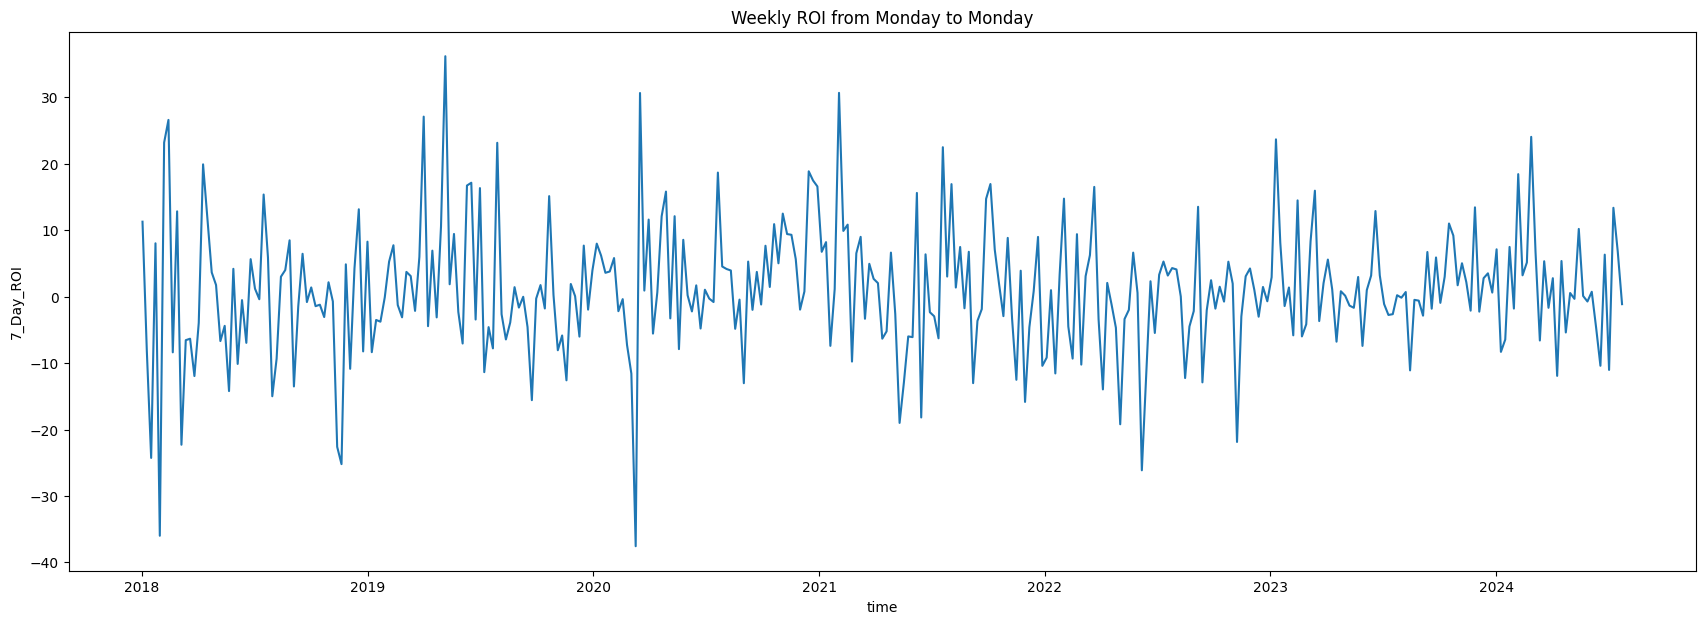

In [90]:
fig, ax= plt.subplots(figsize = (21,7))

sns.lineplot(data= df_roi_mm, x = "time", y = "7_Day_ROI")
plt.title("Weekly ROI from Monday to Monday")


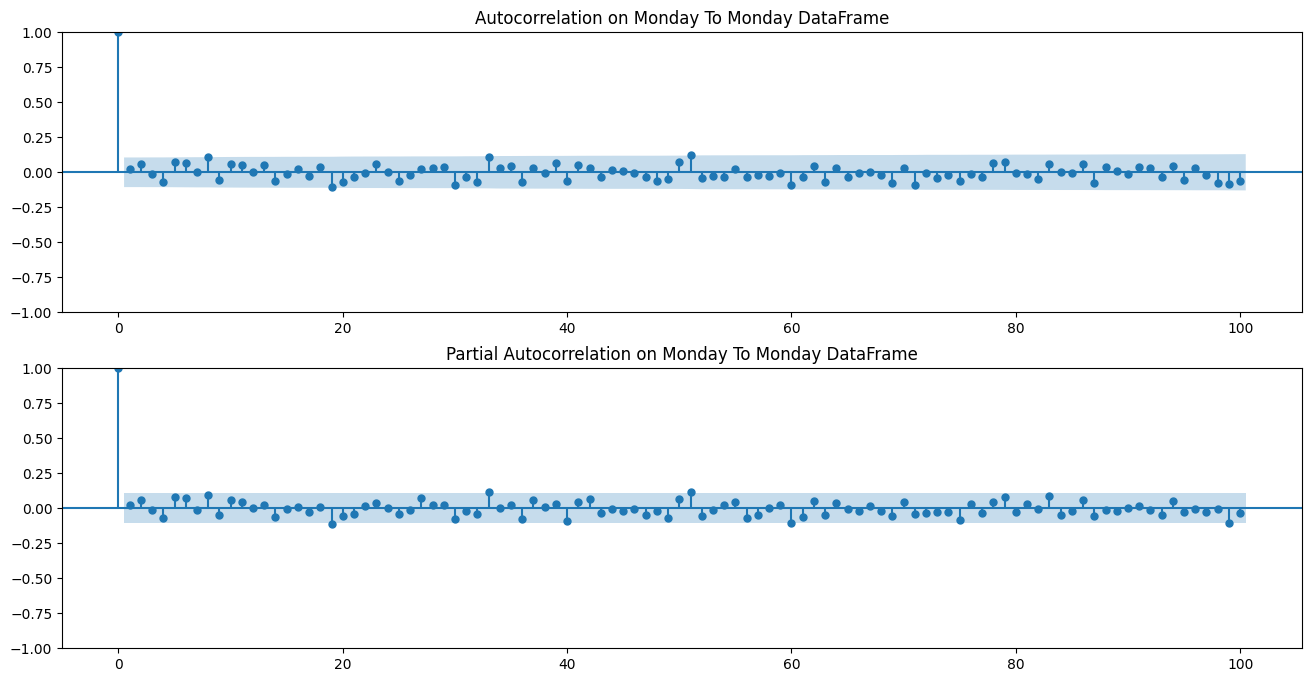

In [13]:
fig, ax= plt.subplots(2,1,figsize = (16,8))

plot_acf(df_roi_mm, lags = 100, ax = ax[0])
plot_pacf(df_roi_mm, lags = 100, ax = ax[1])


ax[0].set_title("Autocorrelation on Monday To Monday DataFrame")
ax[1].set_title("Partial Autocorrelation on Monday To Monday DataFrame")

plt.show()

It seems there is no moving average and auto regressive pattern in the weekly ROI Monday to Monday data.

## Every 8 Hourse Data

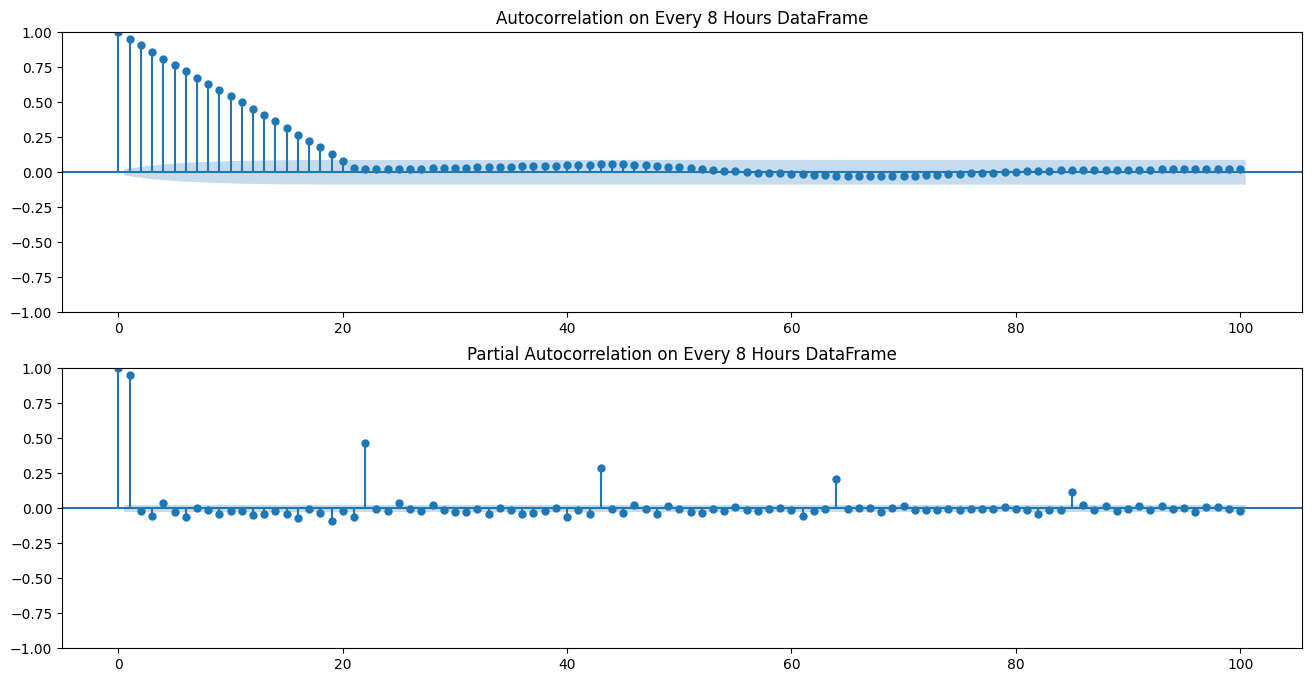

In [14]:
fig, ax= plt.subplots(2,1,figsize = (16,8))

plot_acf(df_roi_8h, lags = 100, ax = ax[0])
plot_pacf(df_roi_8h, lags = 100, ax = ax[1])

ax[0].set_title("Autocorrelation on Every 8 Hours DataFrame")
ax[1].set_title("Partial Autocorrelation on Every 8 Hours DataFrame")

plt.show()

From the above ACF and PACF graphs, it seems the df_roi_8h follows an auto regressive model. The following code snipet shows the order of auto regression model.

In [18]:
pacf_values = pacf(df_roi_8h["7_Day_ROI"], nlags=200)
pretty_print("Lag", "PAC Value")

for i, value in enumerate(pacf_values):
    if value>.25:
        pretty_print(i, round(value,3))

Lag ---------------------- PAC Value
0 ------------------------ 1.0
1 ------------------------ 0.953
22 ----------------------- 0.469
43 ----------------------- 0.289


## Evey 4 Hourse Data

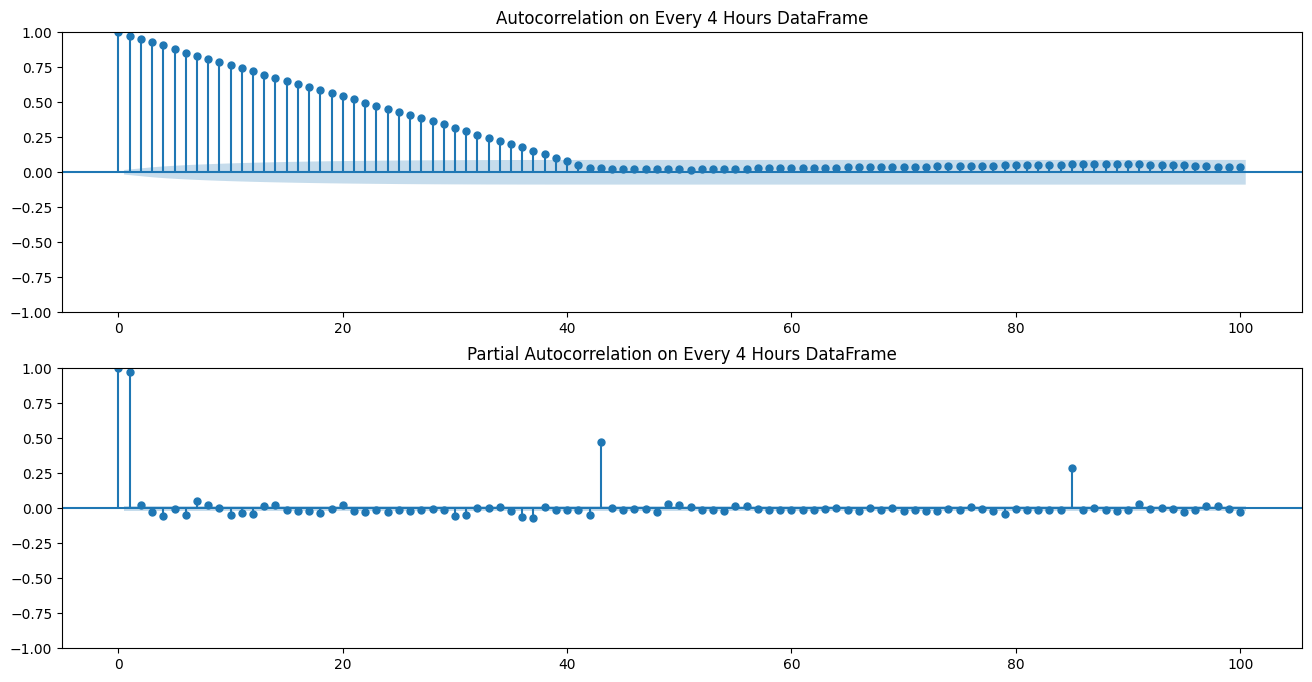

In [15]:
fig, ax= plt.subplots(2,1,figsize = (16,8))

plot_acf(df_roi_4h, lags = 100, ax = ax[0])
plot_pacf(df_roi_4h, lags = 100, ax = ax[1])

ax[0].set_title("Autocorrelation on Every 4 Hours DataFrame")
ax[1].set_title("Partial Autocorrelation on Every 4 Hours DataFrame")

plt.show()

In [19]:
pacf_values = pacf(df_roi_4h["7_Day_ROI"], nlags=200)
pretty_print("Lag", "PAC Value")

for i, value in enumerate(pacf_values):
    if value>.25:
        pretty_print(i, round(value,3))

Lag ---------------------- PAC Value
0 ------------------------ 1.0
1 ------------------------ 0.976
43 ----------------------- 0.476
85 ----------------------- 0.295


# Auto Regressive Model

Based on the above analysis, we understood an Autoregressive model can be a good choice.

## Every 8 Hours Data

In [20]:
split = pd.to_datetime("2023-12-31 20:00:00")
#split_index = df_roi.index.get_loc(split)
train = df_roi_8h.loc[: split]
test  = df_roi_8h.loc[split + timedelta(hours = 8):]
split_index = len(train)
print("Number of data in train:", len(train))
print("Number of data in test:", len(test))

#exact_test  = test[(test.index.hour == 20) &(test.index.weekday == 0)]

Number of data in train: 6573
Number of data in test: 612


In [22]:
ar_model= ARIMA(train, order = ([1,21,42],0,0)).fit()

print(ar_model.summary())

c:\Users\solmaz\anaconda3\envs\TR\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 8h will be used.
  self._init_dates(dates, freq)
c:\Users\solmaz\anaconda3\envs\TR\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 8h will be used.
  self._init_dates(dates, freq)
c:\Users\solmaz\anaconda3\envs\TR\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 8h will be used.
  self._init_dates(dates, freq)
c:\Users\solmaz\anaconda3\envs\TR\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                  SARIMAX Results                                   
Dep. Variable:                    7_Day_ROI   No. Observations:                 6573
Model:             ARIMA([1, 21, 42], 0, 0)   Log Likelihood              -16434.705
Date:                      Sun, 04 Aug 2024   AIC                          32879.410
Time:                              13:14:37   BIC                          32913.364
Sample:                          01-01-2018   HQIC                         32891.147
                               - 12-31-2023                                         
Covariance Type:                        opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8299      0.433      1.917      0.055      -0.018       1.678
ar.L1          0.9561      0.003    358.245      0.000       0.951       0.961
ar.L

Interpreting the result of the model:

- The AR(1) coefficient is highly significant, indicating a strong autoregressive component at lag 1.
- The AR(21) term is also significant but has a negative coefficient, suggesting a negative relationship with the value 21 periods ago.
- The AR(42) coefficient is significant at a lower level, indicating a smaller positive impact from the value 42 periods ago.
- The constant term is marginally insignificant with a p-value of 0.055, suggesting it may not have a substantial effect.
- The sigma2 value indicates the variance of the residuals, with a highly significant coefficient, suggesting the model captures the variance in the data well.

In [28]:
# Mean absolute errors
start_test = test.index[0]
end_test = test.index[-1]
prediction = ar_model.predict()
y_hat = ar_model.predict(start = start_test, end = end_test)
mae = mean_absolute_error(test, y_hat)
print("Mean absolute error:", mae)


Mean absolute error: 5.931233588243626


Text(0.5, 1.0, 'Actual vs. Forecasted Data')

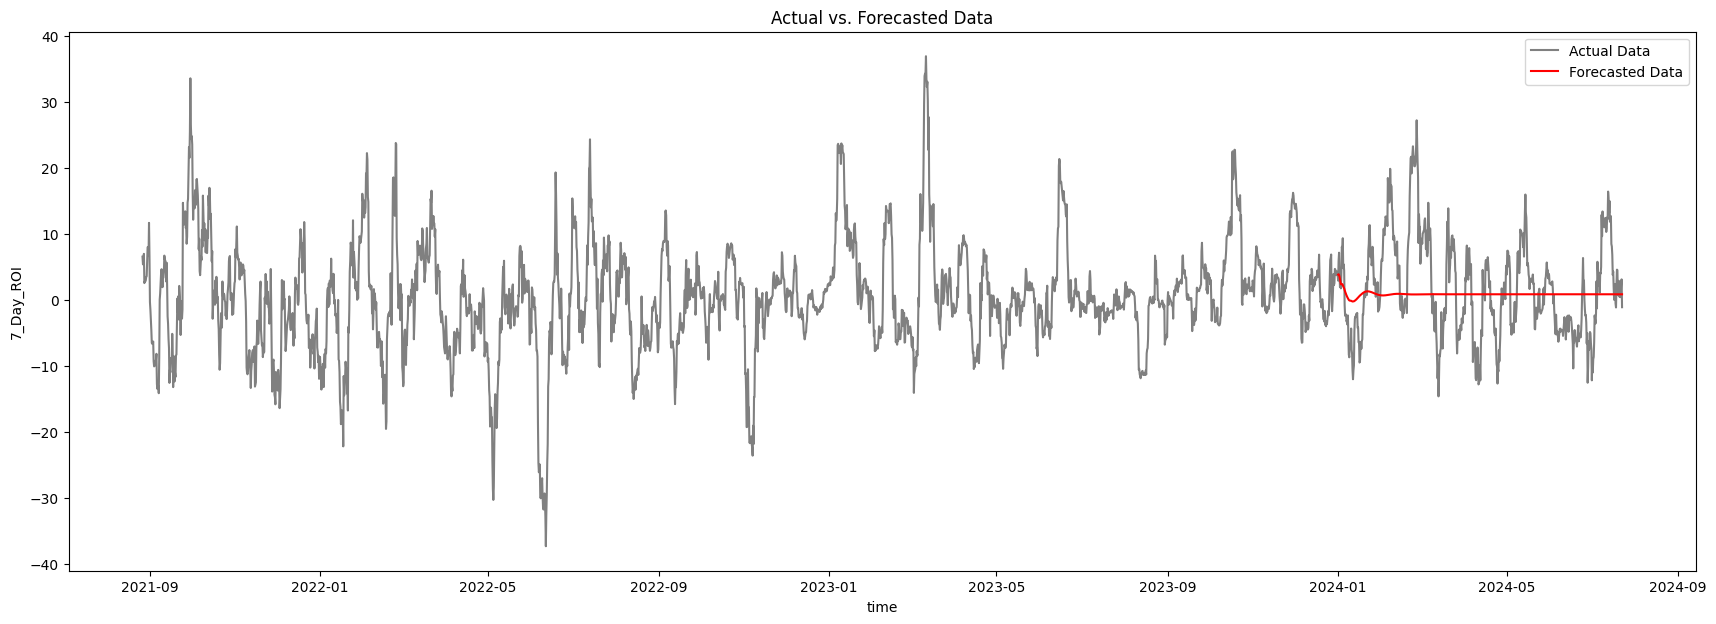

In [27]:
date_range_8h = pd.date_range(start=start_test, end=end_test, freq='8h')

plt.figure(figsize=(21,7))
sns.lineplot(data = df_roi_8h[4000:], x = 'time', y= "7_Day_ROI", color = "gray", label = "Actual Data")
sns.lineplot(x = date_range_8h, y = y_hat, color = "red", label = "Forecasted Data")

plt.legend()

plt.title("Actual vs. Forecasted Data")

It seems that the autoregressive model was not successful in training and could not capture the fluctuations within the data.

## Every 4 hours Data

In [29]:
split = pd.to_datetime("2023-12-31 20:00:00")
#split_index = df_roi.index.get_loc(split)
train = df_roi_4h.loc[: split]
test  = df_roi_4h.loc[split + timedelta(hours = 8):]
split_index = len(train)
print("Number of data in train:", len(train))
print("Number of data in test:", len(test))

Number of data in train: 13146
Number of data in test: 1224


In [31]:
ar_model= ARIMA(train, order = ([1,42,84],0,0)).fit()

print(ar_model.summary())

c:\Users\solmaz\anaconda3\envs\TR\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 4h will be used.
  self._init_dates(dates, freq)
c:\Users\solmaz\anaconda3\envs\TR\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 4h will be used.
  self._init_dates(dates, freq)
c:\Users\solmaz\anaconda3\envs\TR\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 4h will be used.
  self._init_dates(dates, freq)
c:\Users\solmaz\anaconda3\envs\TR\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                  SARIMAX Results                                   
Dep. Variable:                    7_Day_ROI   No. Observations:                13146
Model:             ARIMA([1, 42, 84], 0, 0)   Log Likelihood              -28570.108
Date:                      Sun, 04 Aug 2024   AIC                          57150.216
Time:                              13:44:10   BIC                          57187.635
Sample:                          01-01-2018   HQIC                         57162.712
                               - 12-31-2023                                         
Covariance Type:                        opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8309      0.429      1.936      0.053      -0.010       1.672
ar.L1          0.9772      0.001    721.116      0.000       0.975       0.980
ar.L

In [33]:
# Mean absolute errors
start_test = test.index[0]
end_test = test.index[-1]
prediction = ar_model.predict()
y_hat = ar_model.predict(start = start_test, end = end_test)
mae = mean_absolute_error(test, y_hat)
print("Mean absolute error:", mae)

Mean absolute error: 5.904715245505615


Text(0.5, 1.0, 'Actual vs. Forecasted Data')

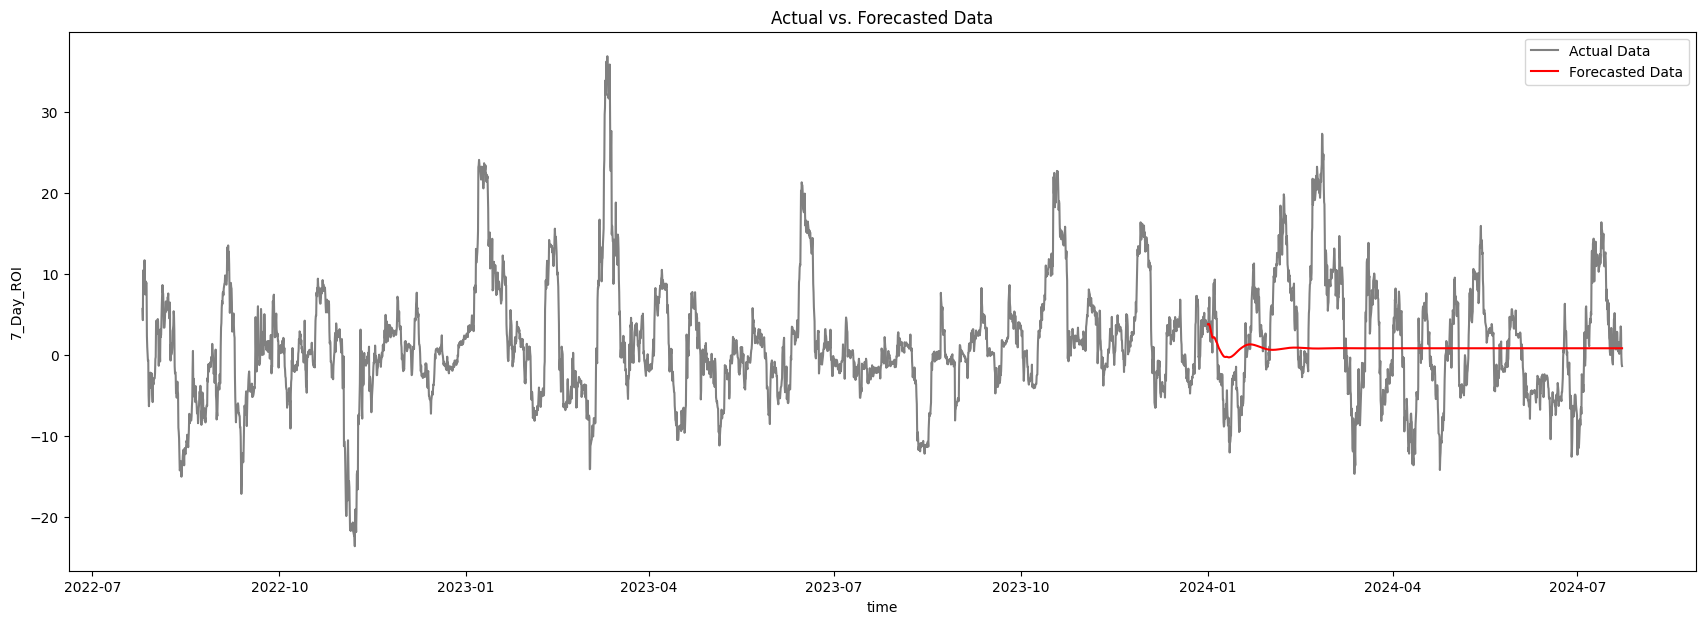

In [37]:
date_range_4h = pd.date_range(start=start_test, end=end_test, freq='4h')

plt.figure(figsize=(21,7))
sns.lineplot(data = df_roi_4h[10000:], x = 'time', y= "7_Day_ROI", color = "gray", label = "Actual Data")
sns.lineplot(x = date_range_4h, y = y_hat, color = "red", label = "Forecasted Data")

plt.legend()

plt.title("Actual vs. Forecasted Data")

The performance of the AR models on both DataFrames are the same; they could not capture the patterns in the data well.